In [5]:
import torch
from datasets import load_dataset
import transformers
import pandas as pd
import numpy as np

In [52]:
emotions = load_dataset('Emotion')

In [53]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
len(emotions["train"])

16000

In [20]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [23]:
emotions.reset_format()

In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_id = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [25]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [54]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:
emotions_encoded.column_names

{'train': ['text', 'label', 'input_ids', 'attention_mask'],
 'validation': ['text', 'label', 'input_ids', 'attention_mask'],
 'test': ['text', 'label', 'input_ids', 'attention_mask']}

In [33]:
num_labels = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [35]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy, "f1": f1}

In [36]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions["train"]) // batch_size
model_name = f"{model_id}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error")

2023-12-20 17:07:42.348291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/spack/anvil/apps/texlive/20200406-gcc-8.4.1-gjynmo4/lib:/apps/spack/anvil/apps/zlib/1.2.11-gcc-8.4.1-dif34jo/lib:/apps/spack/anvil/apps/mpfr/4.0.2-gcc-8.4.1-zqh4s5a/lib:/apps/spack/anvil/apps/gmp/6.2.1-gcc-8.4.1-a4uy3yg/lib
2023-12-20 17:07:42.348327: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [38]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics, 
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
                  
trainer.train();

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.880100,0.340823,0.898500,0.898024
2,0.266300,0.225931,0.922500,0.922586


In [39]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [40]:
preds_output.metrics

{'test_loss': 0.22593140602111816,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225856949917518,
 'test_runtime': 1.0026,
 'test_samples_per_second': 1994.719,
 'test_steps_per_second': 31.916}

In [41]:
y_preds = np.argmax(preds_output.predictions, axis=1)

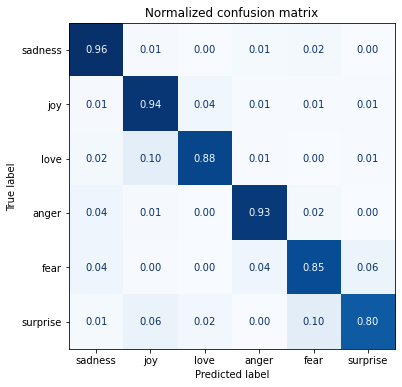

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_val = emotions_encoded["validation"]["label"]
plot_confusion_matrix(y_preds, y_val, ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [49]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
    reduction="none")

    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [55]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [65]:
emotions_encoded.set_format(type="pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"]
df_test["predicted_label"] = (df_test["predicted_label"])

In [66]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,5,0,5.661766
1801,i feel that he was being overshadowed by the s...,2,0,5.549235
882,i feel badly about reneging on my commitment t...,2,0,5.481410
1963,i called myself pro life and voted for perry w...,1,0,5.235965
1870,i guess i feel betrayed because i admired him ...,1,0,4.852779
1274,i am going to several holiday parties and i ca...,1,0,4.849475
1500,i guess we would naturally feel a sense of lon...,3,0,4.809706
318,i felt ashamed of these feelings and was scare...,4,0,4.709445
1509,i guess this is a memoir so it feels like that...,1,4,4.580043
465,i would eventually go in to these stores but i...,1,4,4.556682


In [67]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1263,i feel this way about blake lively,1,1,0.017838
19,i had lunch with an old friend and it was nice...,1,1,0.017924
604,i don t like to use the h word recklessly but ...,1,1,0.018196
1505,im feeling hopeful about a great deal of thing...,1,1,0.018346
1873,i feel practically virtuous this month i have ...,1,1,0.018446
1638,i feel like if you shop smart you can still ad...,1,1,0.018523
1147,i type i feel bouncy and excited to get out my...,1,1,0.018530
1308,i feel there are very smart people that can co...,1,1,0.018647
928,i feel sure that were i placed into a spanish ...,1,1,0.018704
632,i feel he is an terrific really worth bet,1,1,0.018786
